# Melanoma Detection Assignment
This assignment is to build a CNN based model which can accurately detect melanoma. This involves training the pre categorized images of different types of skin cancer types and prepare a model to accuratly detect melanoma skin cancer.


## Table of Contents
* [General Info](#general-information)
* [Importing all the important libraries](#importing-libraries)
* [Data Preparation and Initial Assessment](#data-preparation-and-initial-asssessment)
* [Visualize Data](#visualize-data)
* [Model#1 - With Normalization](#model#1)
* [Model#2 - With Data Augmentation, Normalization & Dropout](#model#2)
* [Handle Class Imbalance](#handle-class-imbalance)
* [Model#3 - With Augmented(Class Balanced) Data](#model#3)
* [Model#4 - With Normalization, Dropouts, Regularization & Class balanced data](#model#4)
* [Summary](#summary)

<a name="general-information"></a>
### **General Information**

**Background**

  This project is part of the PG Program in AI & ML program, specifically within a Deep Learning course.

**Goal**

  To build a CNN based model which can accurately detect melanoma.

**Business Problem**

  Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

**Dataset**

  The dataset consists of 2357 images which were formed from the International Skin Imaging Collaboration (ISIC).

  The data set contains the following skin diseases:

*   Actinic keratosis
*   Basal cell carcinoma
*   Dermatofibroma
*   Melanoma
*   Nevus
*   Pigmented benign keratosis
*   Seborrheic keratosis
*   Squamous cell carcinoma
*   Vascular lesion


<a name="importing-libraries"></a>
### **Importing all the important libraries**

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import PIL
import random
from glob import glob
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.layers import Rescaling, Input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img

<a name="data-preparation-and-initial-assessment"></a>
### **Data preparation and initial assessment**
Define default parameters and load dataset


#### Drive Mount and Define Path

In [2]:
# Mount google drive for accessing dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Setting base path of dataset
base_path='/content/drive/My Drive/ML_AI/CNN_Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/'

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path(base_path + "Train")
data_dir_test = pathlib.Path(base_path + "Test")

In [5]:
# Find image count from Train and Test folders of dataset
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print('Train Images : ', image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print('Test Images  : ',image_count_test)

Train Images :  2239
Test Images  :  118



> Dataset have 2239 Train images and 118 Test images



#### Clean up dataset



In [6]:
# Safe clean up of output folders (if any) created by augumentor in previous execution
import shutil
path_to_training_dataset=str(data_dir_train) + '/'

for folder_name in os.listdir(path_to_training_dataset):
    output_folder = os.path.join(path_to_training_dataset, folder_name, "output")
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)
        print(f"Deleted output folder for class: {folder_name}")
    else:
        print(f"Output folder for class {folder_name} not found. No action required.")

Deleted output folder for class: vascular lesion
Deleted output folder for class: seborrheic keratosis
Deleted output folder for class: basal cell carcinoma
Deleted output folder for class: pigmented benign keratosis
Deleted output folder for class: dermatofibroma
Deleted output folder for class: squamous cell carcinoma
Deleted output folder for class: melanoma
Deleted output folder for class: nevus
Deleted output folder for class: actinic keratosis


#### Data Preparation

In [7]:
# Define default parameters
batch_size = 32
img_height = 180
img_width = 180

In [8]:
# Loading images from directory using Keras.

# Training Data Set :: 80% of images from Train Directory
train_ds = image_dataset_from_directory(
    directory=data_dir_train,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset="training",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123
)

# Validation Data Set :: 20% of images from Train Directory
val_ds = image_dataset_from_directory(
    directory=data_dir_train,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset="validation",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123
)

# Test Data Set :: All images from Test Directory
test_ds = image_dataset_from_directory(
    directory=data_dir_test,
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False,
    seed=123
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.
Found 118 files belonging to 9 classes.


>   This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.



In [9]:
# Get Class names for further reference
class_names = train_ds.class_names
num_classes =len(class_names)
print('Class Count        :', num_classes)
print('Categories/Classes :', class_names)

# Print batch shape
for image_batch, labels_batch in train_ds:
    print('Image  Batch Shape : ',image_batch.shape)
    print('Labels Batch Shape : ',labels_batch.shape)
    break

Class Count        : 9
Categories/Classes : ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Image  Batch Shape :  (32, 180, 180, 3)
Labels Batch Shape :  (32,)


> The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.



In [10]:
# Load dataset to cache for faster access
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
train_ds= train_ds.cache().prefetch(buffer_size=AUTOTUNE)

<a name="visualize-data"></a>
### **Visualize the data**
Plot images to visualize each class/category

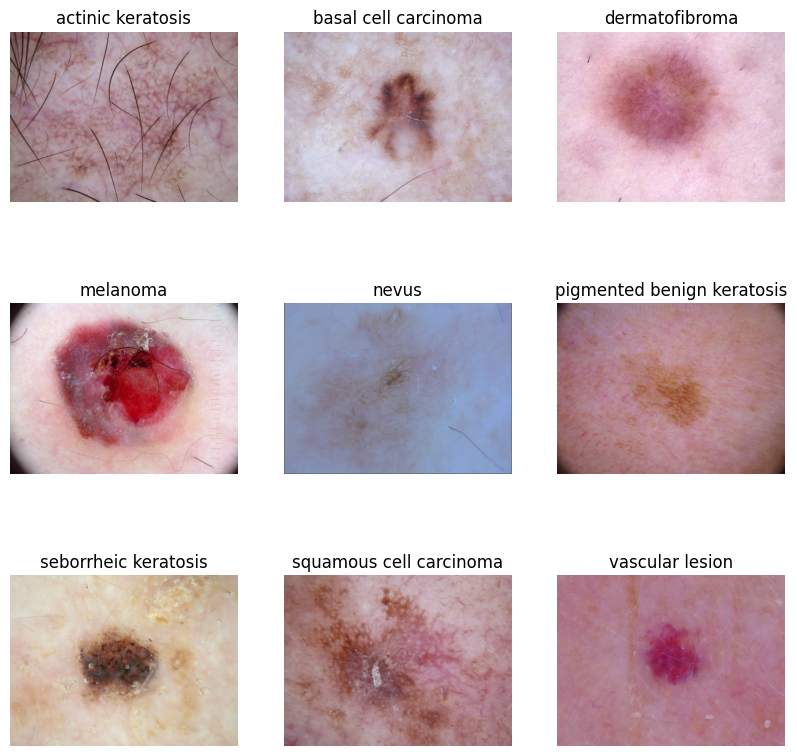

In [11]:
# Visualize one image from each class/directory
plt.figure(figsize=(10, 10))
for i,category in enumerate(class_names):
  cat_path=os.path.join(data_dir_train, category)
  image_files = os.listdir(cat_path)
  img = plt.imread(os.path.join(cat_path,image_files[0]))
  plt.subplot(3, 3, i + 1)
  plt.imshow(img)
  plt.title(category)
  plt.axis('off')
plt.show()

> Visually each class have unique characterstics



<a name="Reusable-functions"></a>
### **Define Reusable Functions**
Defining functions for all steps in model building, evaluation

In [12]:
# Function to compile model and print model summary. Returns Model for further processing
def compile_model(model):
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  model.summary()
  return model

In [13]:
# Function to train model. Returns history, best model and epochs trained for further processing
# Earlystopping is set with monitoring on val_accuracy and patience level 10
def train_model(model, train_ds, val_ds,epochs):
  from tensorflow.keras.models import load_model

  checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy',save_best_only=True, mode='max', verbose=1)
  earlystop = EarlyStopping(monitor='val_accuracy', patience=10,mode='max', verbose=1)

  history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      callbacks=[checkpoint, earlystop]
  )

  best_model = load_model("best_model.keras")

  if earlystop.stopped_epoch==0:
    epoch_range=epochs
  else:
    epoch_range=earlystop.stopped_epoch+1

  return history,best_model,epoch_range

In [14]:
# Function to plot accuray & loss
def plot_accuracy_loss(history,epoch_range):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epoch_range)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [15]:
# Function to predict for a random image in random class
def predict_model(trained_model):
  loss, accuracy = trained_model.evaluate(test_ds)
  print('Test accuracy:', accuracy)

  print('\nPrediction Random Image from Random Class :\n')

  random_class=class_names[random.randint(0, 8)]
  random_image_path = random.choice(glob(os.path.join(data_dir_test, random_class, '*')))

  Test_image = load_img(random_image_path,target_size=(180,180,3))
  plt.imshow(Test_image)
  plt.grid(False)

  img = np.expand_dims(Test_image,axis=0)
  pred = trained_model.predict(img)
  pred = np.argmax(pred)
  pred_class = class_names[pred]
  print("Actual Class "+ random_class +'\n'+ "Predictive Class "+pred_class )
  plt.axis('off')
  plt.show()

<a name="model#1"></a>
### **Model#1 - With Normalization**

*   CNN model with normalization and three convolution layers
*   No dropout or regularization used in this initial model.

In [16]:
# Define the CNN model
model = Sequential([
  layers.InputLayer(shape=(img_height, img_width, 3)),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [17]:
# Compile model
model=compile_model(model)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train model with 20 epochs
history,best_model,epoch_range = train_model(model, train_ds, val_ds,20)

Epoch 1/20
53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2197 - loss: 2.0178
Epoch 1: val_accuracy improved from -inf to 0.38031, saving model to best_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 166s 604ms/step - accuracy: 0.2230 - loss: 2.0111 - val_accuracy: 0.3803 - val_loss: 1.8002
Epoch 2/20
53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4149 - loss: 1.6664
Epoch 2: val_accuracy improved from 0.38031 to 0.44743, saving model to best_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4171 - loss: 1.6609 - val_accuracy: 0.4474 - val_loss: 1.5380
Epoch 3/20
53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4932 - loss: 1.4609
Epoch 3: val_accuracy improved from 0.44743 to 0.54362, saving model to best_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4940 - loss: 1.4570 - val_accuracy: 0.5436 - val_loss: 1.3519
Epoch 4/20
53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5354 - loss: 1.3211
Epoch 4: val_accuracy did not improve from 0.

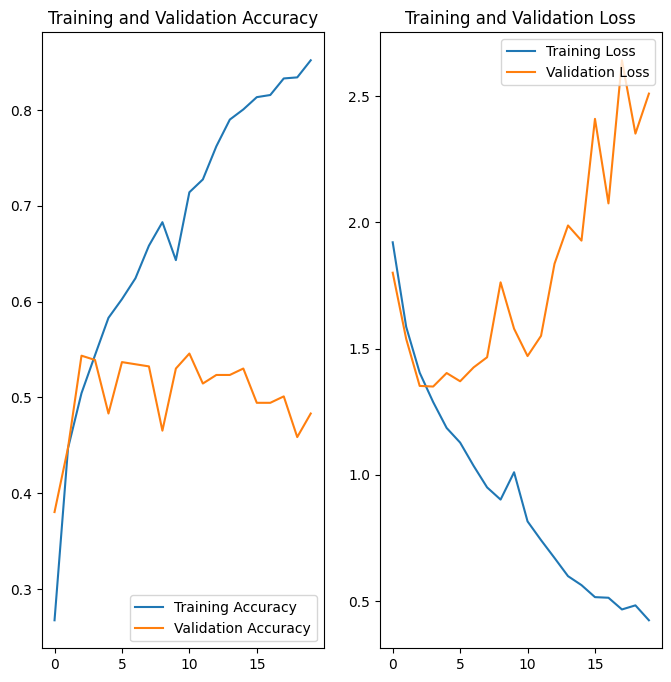

In [19]:
# Plot accurancy and loss
plot_accuracy_loss(history,epoch_range)

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.3106 - loss: 2.9947
Test accuracy: 0.33898305892944336

Prediction Random Image from Random Class :

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
Actual Class nevus
Predictive Class nevus


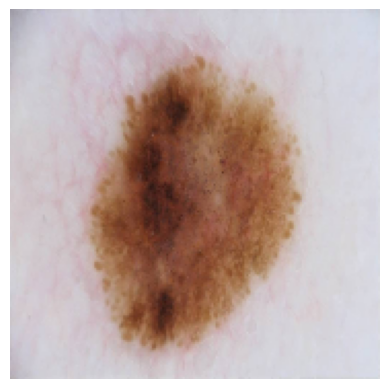

In [20]:
# Predict using trained model
predict_model(best_model)

**Findings:**


*   Model is overfit with validation accuracy at 56% while training accurancy reached 88%.
*   Test accuracy stands at 39%.







<a name="model#2"></a>
### **Model#2 - With Data Augmentation, Normalization & Dropout**


*   To mitigate overfitting from previous model, introducing data augmentation and dropouts.
*   CNN model with data augmentation (flip, rotation, Zoom, Brightness & contrast), normalization and three convolution layers with dropouts



In [21]:
# Define data augmentation layers
data_augmentation = tf.keras.Sequential([
    layers.InputLayer(shape=(img_height, img_width, 3)),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomContrast(0.2),
])

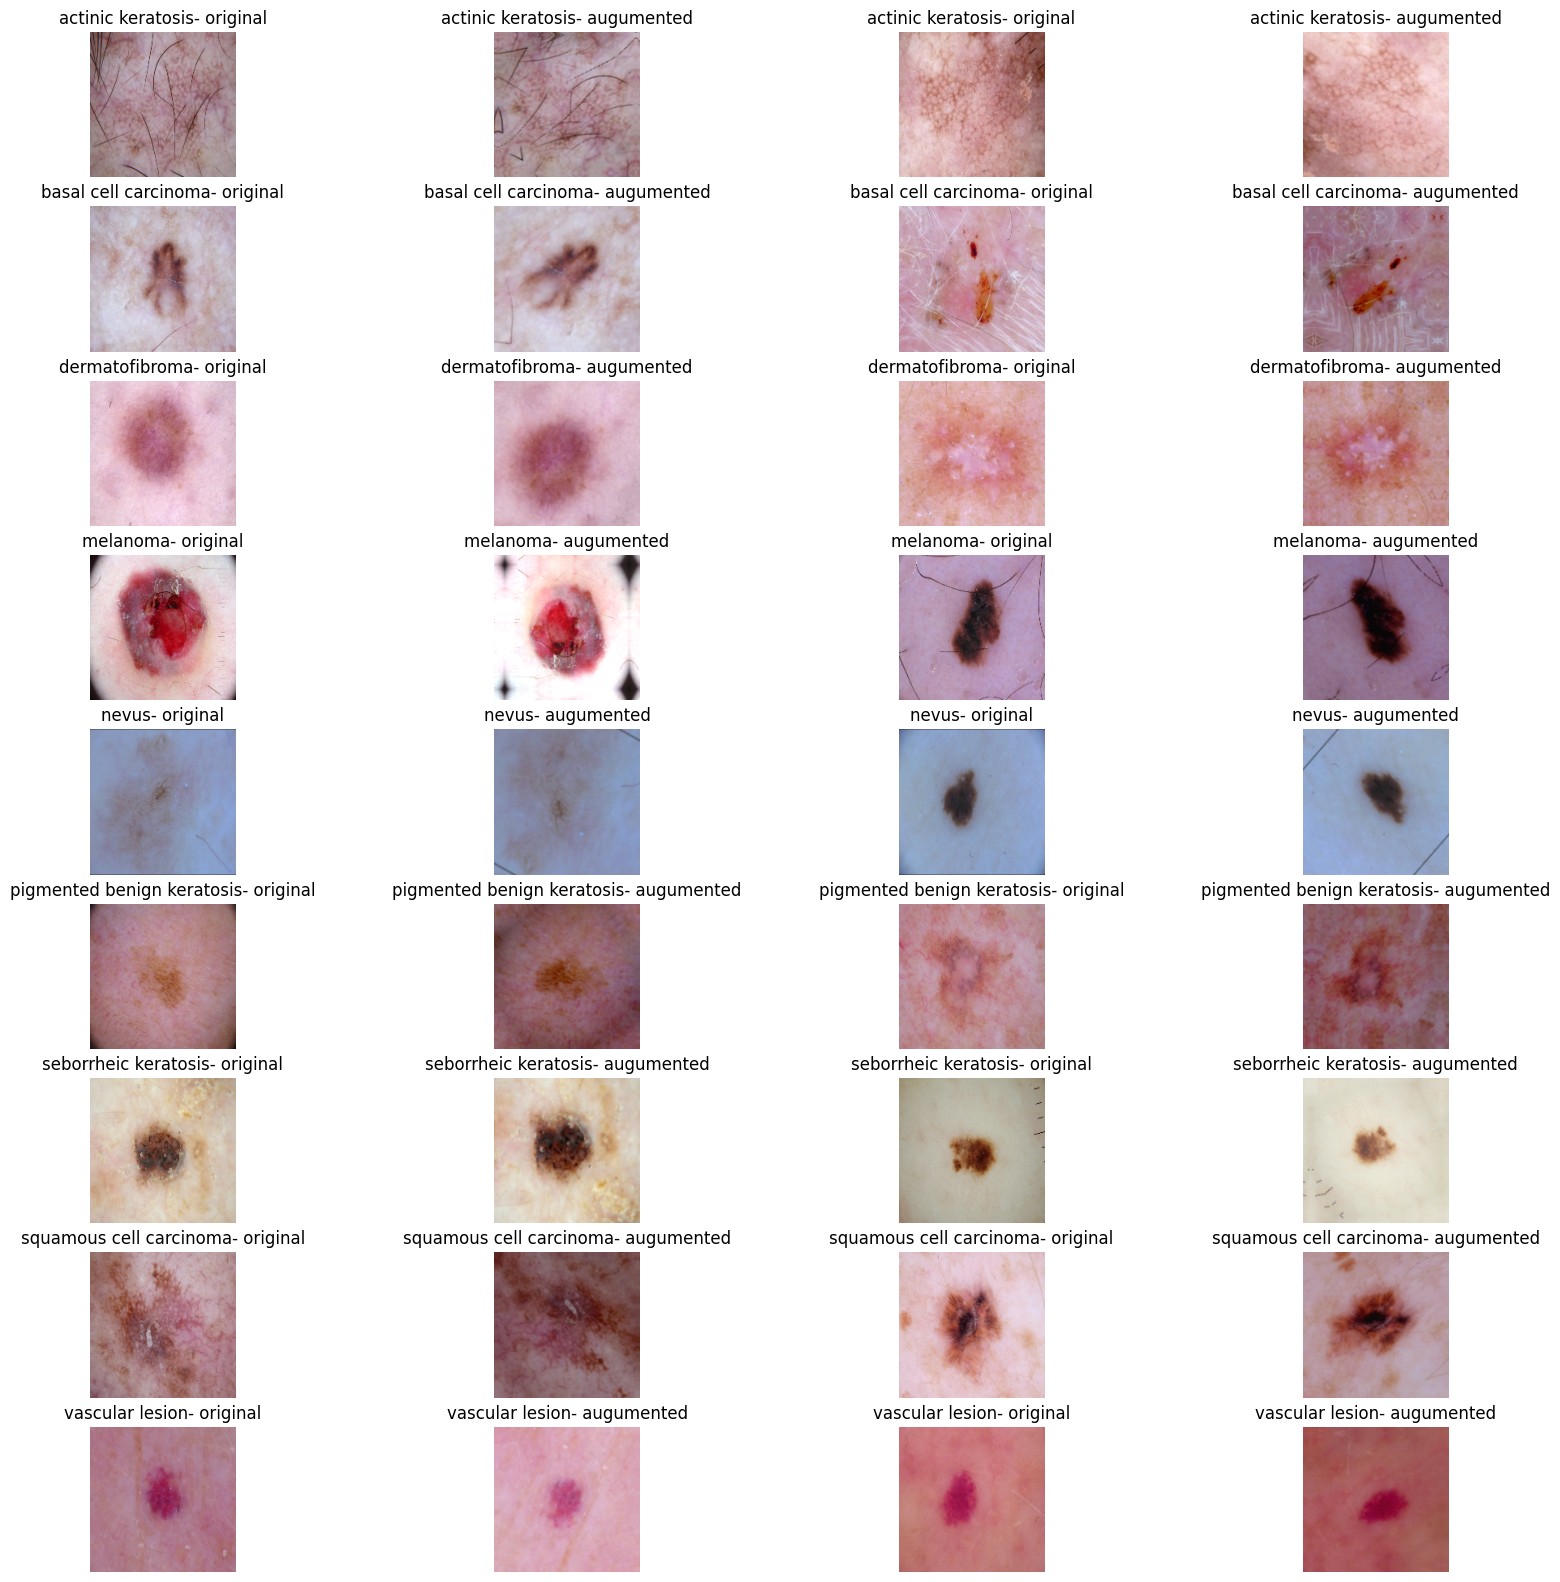

In [22]:
# Plot two images from each class to visualize impact of data augmentation
plt.figure(figsize=(20, 20))
i=0
for category in class_names:
  cat_path=os.path.join(data_dir_train, category)
  image_files = os.listdir(cat_path)
  for j in range(2):
    img = plt.imread(os.path.join(cat_path,image_files[j]))
    img = tf.image.resize(img, [img_height, img_width])

    i += 1
    plt.subplot(9, 4, i)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(category + '- original')
    plt.axis('off')

    i += 1
    plt.subplot(9, 4, i)
    img_batch = tf.expand_dims(img, axis=0)
    plt.imshow(data_augmentation(img_batch).numpy()[0].astype("uint8"))
    plt.title(category + '- augumented')
    plt.axis('off')
plt.show()

In [23]:
# Define the CNN model
model = Sequential([
  layers.InputLayer(shape=(img_height, img_width, 3)),
  data_augmentation,      # Added data augmentation layers
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),   # Added dropout
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),   # Added dropout
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),   # Added dropout
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [24]:
# Compile model
model=compile_model(model)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Train model
history,best_model,epoch_range = train_model(model, train_ds, val_ds,20)

Epoch 1/20
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1645 - loss: 2.4099
Epoch 1: val_accuracy improved from -inf to 0.19687, saving model to best_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.1652 - loss: 2.4010 - val_accuracy: 0.1969 - val_loss: 2.0707
Epoch 2/20
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2691 - loss: 1.9539
Epoch 2: val_accuracy improved from 0.19687 to 0.22148, saving model to best_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.2701 - loss: 1.9522 - val_accuracy: 0.2215 - val_loss: 2.0196
Epoch 3/20
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3681 - loss: 1.7766
Epoch 3: val_accuracy improved from 0.22148 to 0.27517, saving model to best_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.3681 - loss: 1.7753 - val_accuracy: 0.2752 - val_loss: 1.9712
Epoch 4/20
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4135 - loss: 1.6774
Epoch 4: val_accuracy improved from 0.27517 to 0

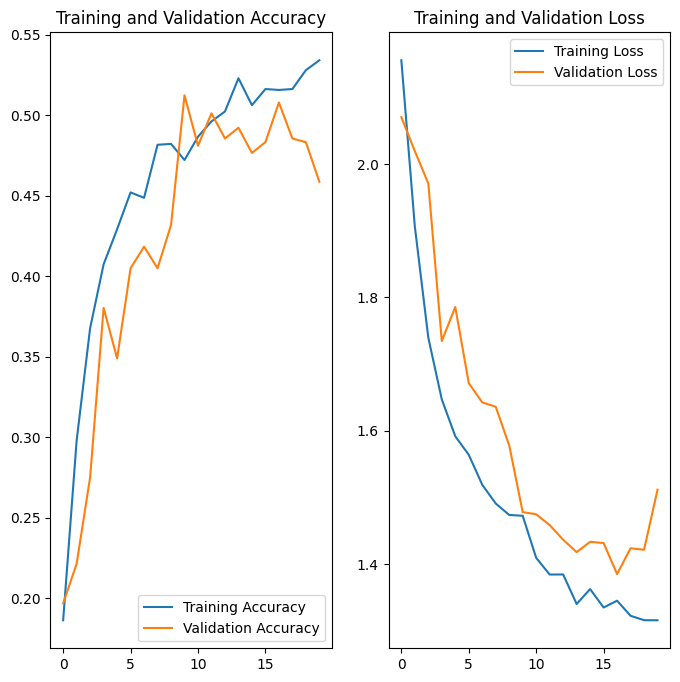

In [26]:
# Plot accurancy and loss
plot_accuracy_loss(history,epoch_range)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step - accuracy: 0.2585 - loss: 2.0731
Test accuracy: 0.3050847351551056

Prediction Random Image from Random Class :

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Actual Class melanoma
Predictive Class nevus


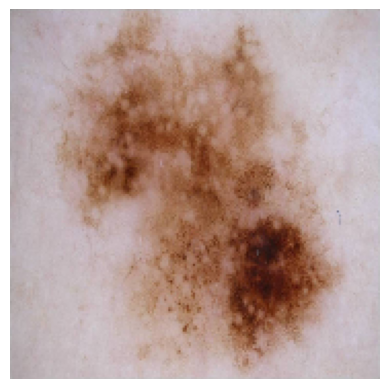

In [27]:
# Predict using trained model
predict_model(best_model)

**Findings:**


*   Overfit issue is now resolved but now underfit issue surfaced with low training accuracy at 51.
*   Test accuracy stands at 30, but random prediction succeeded.



<a name="handle-class-imbalance"></a>
### **Handle Class Imbalance**


*   Identify class imbalance and handle using augmentor


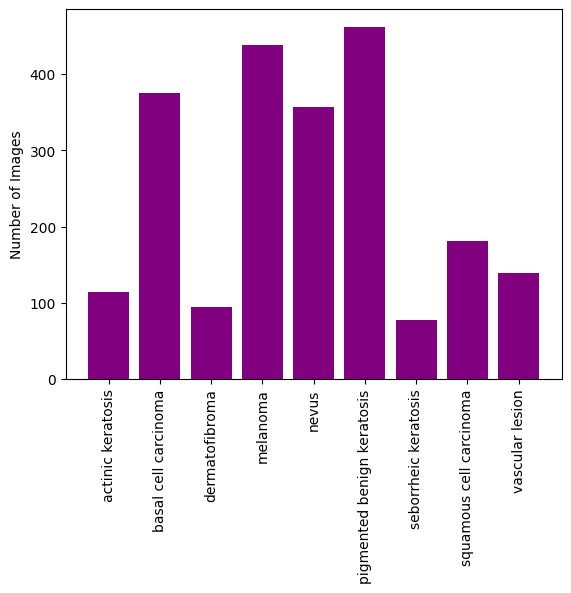

In [28]:
# Plot number of images per each class/category
counts = [len(os.listdir(os.path.join(data_dir_train, cat))) for cat in class_names]

plt.bar(class_names, counts,color='purple')
plt.xticks(rotation=90)
plt.ylabel("Number of Images")
plt.show()



> Above bar plot clearly shows class imbalance in dataset


*   'pigmented benign keratosis' class have highest number of images
*   'seborrheic keratosis' class have lowest number of images





In [29]:
# Install Augmentor to create augmented images to mitigate class imbalance
!pip install Augmentor

In [30]:
# Prepare pipeline for augmentor to add augmented images to minor classes.
# Preferred to add samples based on original counts. Included most kinds of augmentation techniques (rotate,flip,zoom,crop)

import Augmentor
num_augmented_images_max = 1000 #Minimum images intended for each class

for class_name in class_names:
    class_path = os.path.join(path_to_training_dataset, class_name)
    num_original_images = len(glob(os.path.join(class_path, '*.jpg')))

    if num_original_images < num_augmented_images_max:
        p = Augmentor.Pipeline(class_path)
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
        p.flip_left_right(probability=0.3)
        p.zoom(probability=0.3, min_factor=1.1, max_factor=1.5)
        p.crop_random(probability=0.3, percentage_area=0.8)

        num_augmented_images=num_augmented_images_max - num_original_images #Images to be augmented

        p.sample(num_augmented_images)
        print(f"====> Class '{class_name}' |  Original Images : {num_original_images} | Augmented Images : {num_augmented_images}")
    else:
        print(f"====> {class_name} is not a minor class (has {num_original_images} images). Skipping augmentation.")

Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/ML_AI/CNN_Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79438F325B10>: 100%|██████████| 886/886 [00:11<00:00, 77.12 Samples/s]


====> Class 'actinic keratosis' |  Original Images : 114 | Augmented Images : 886
Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/ML_AI/CNN_Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=480x360 at 0x79438CFD0D30>: 100%|██████████| 624/624 [00:07<00:00, 86.94 Samples/s]


====> Class 'basal cell carcinoma' |  Original Images : 376 | Augmented Images : 624
Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/ML_AI/CNN_Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7943581CBE80>: 100%|██████████| 905/905 [00:10<00:00, 86.05 Samples/s]


====> Class 'dermatofibroma' |  Original Images : 95 | Augmented Images : 905
Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/ML_AI/CNN_Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x79438EDEE0B0>: 100%|██████████| 562/562 [00:21<00:00, 25.89 Samples/s]


====> Class 'melanoma' |  Original Images : 438 | Augmented Images : 562
Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/ML_AI/CNN_Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2592x1944 at 0x79438F24A0B0>: 100%|██████████| 643/643 [00:25<00:00, 25.65 Samples/s]


====> Class 'nevus' |  Original Images : 357 | Augmented Images : 643
Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/ML_AI/CNN_Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79435859BB20>: 100%|██████████| 538/538 [00:06<00:00, 86.98 Samples/s]


====> Class 'pigmented benign keratosis' |  Original Images : 462 | Augmented Images : 538
Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/ML_AI/CNN_Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=819x614 at 0x794358429A20>: 100%|██████████| 923/923 [00:18<00:00, 49.90 Samples/s]


====> Class 'seborrheic keratosis' |  Original Images : 77 | Augmented Images : 923
Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/ML_AI/CNN_Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7943585F4130>: 100%|██████████| 819/819 [00:09<00:00, 84.12 Samples/s]


====> Class 'squamous cell carcinoma' |  Original Images : 181 | Augmented Images : 819
Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/ML_AI/CNN_Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7943584773A0>: 100%|██████████| 861/861 [00:10<00:00, 83.10 Samples/s]

====> Class 'vascular lesion' |  Original Images : 139 | Augmented Images : 861


In [31]:
# Augmentor stores augmented images in 'output' sub-directory in each class directory.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

6761


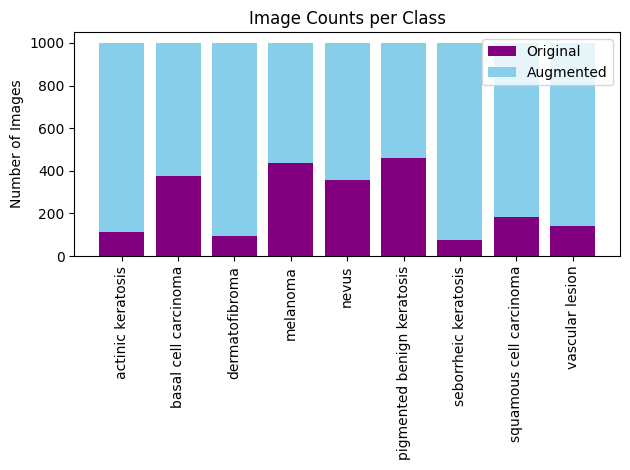

In [32]:
# Plot train dataset with augmented data
original_img_counts = {category: len(list(glob(os.path.join(data_dir_train, category, '*.jpg')))) for category in class_names}
augmented_img_counts = {category: len(list(glob(os.path.join(data_dir_train, category, 'output', '*.jpg')))) for category in class_names}

fig, ax = plt.subplots()
# Pass class_names as x and the corresponding values from original_img_counts as height
ax.bar(class_names, [original_img_counts.get(name, 0) for name in class_names], label='Original',color='purple')
ax.bar(class_names, [augmented_img_counts.get(name, 0) for name in class_names], bottom=[original_img_counts.get(name, 0) for name in class_names], label='Augmented',color='skyblue')

ax.set_ylabel('Number of Images')
ax.set_title('Image Counts per Class')
ax.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

> After augmentation, we can see all classes have same number of samples in train dataset.



In [33]:
# Re-Define Train and Valiadtion datasets using Original+Augmented Data

# Training Data Set :: 70% of images from Train + Augmented Directory
train_ds = image_dataset_from_directory(
    directory=data_dir_train,
    labels='inferred',
    label_mode='int',
    validation_split=0.3,
    subset="training",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123
)

# Validation Data Set :: 30% of images from Train + Augmented Directory
val_ds = image_dataset_from_directory(
    directory=data_dir_train,
    labels='inferred',
    label_mode='int',
    validation_split=0.3,
    subset="validation",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False,
    seed=123
)

Found 9000 files belonging to 9 classes.
Using 6300 files for training.
Found 9000 files belonging to 9 classes.
Using 2700 files for validation.


In [34]:
# Cache new datasets
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Findings:**


*   Class imbalance is mitigated using Augmentor which helped in adding augmented images based on original images in respective class directory.
*   Post augmentation, all classes have same number of samples which confirms no more class imbalance.

*   Test/Validation split changed to 30%. 6300 images used for training and 2700 images used for validation. No change in Test dataset which is having 118 images in total






<a name="model#3"></a>
### **Model#3 - With Augmented(Class Balanced) Data**

*   Model with normalization, three convolutional layers with dropouts.
*   Trained on Augmented/Class Balanced data

In [35]:
# Define the CNN model
model = Sequential([
  layers.InputLayer(shape=(img_height, img_width, 3)),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [36]:
# Compile new model
model=compile_model(model)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Train model with 50 epochs
history,best_model,epoch_range = train_model(model, train_ds, val_ds,50)

Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1060 - loss: 2.9148
Epoch 1: val_accuracy improved from -inf to 0.03704, saving model to best_model.keras
197/197 ━━━━━━━━━━━━━━━━━━━━ 33s 76ms/step - accuracy: 0.1061 - loss: 2.9120 - val_accuracy: 0.0370 - val_loss: 2.1920
Epoch 2/50
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1285 - loss: 2.1752
Epoch 2: val_accuracy improved from 0.03704 to 0.48370, saving model to best_model.keras
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.1288 - loss: 2.1742 - val_accuracy: 0.4837 - val_loss: 1.4835
Epoch 3/50
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3543 - loss: 1.6828
Epoch 3: val_accuracy improved from 0.48370 to 0.54926, saving model to best_model.keras
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.3546 - loss: 1.6820 - val_accuracy: 0.5493 - val_loss: 1.2301
Epoch 4/50
195/197 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4767 - loss: 1.3845
Epoch 4: val_accuracy did not imp

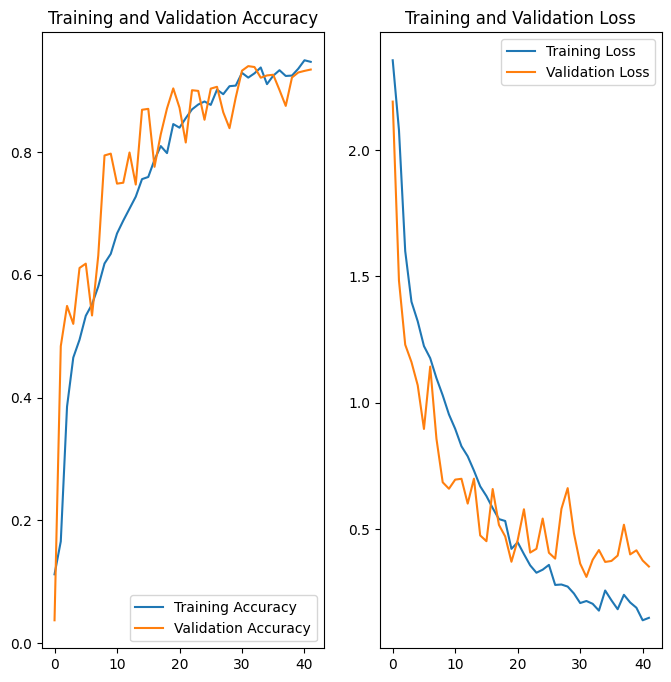

In [38]:
# Plot accurancy and loss
plot_accuracy_loss(history,epoch_range)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - accuracy: 0.3460 - loss: 6.0009
Test accuracy: 0.4067796468734741

Prediction Random Image from Random Class :

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Actual Class vascular lesion
Predictive Class vascular lesion


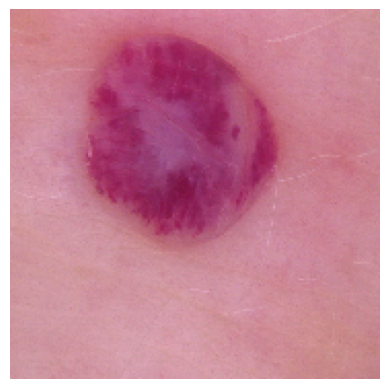

In [39]:
# Predict using trained model
predict_model(best_model)

**Findings:**


*   Augmentor helped in resolving underfit by mitigating class imbalance.
*   Train accuracy stands at 95% and validation accuracy at 94%
*   Test accurancy still not the best as its around 40%
*   To improvde detection accuracy, more complexity model needs to be built considering other architectures or using tranfer learning.







<a name="summary"></a>
### Summary

**Technical Conclusion:**

* Three CNN models were developed and evaluated for skin cancer classification.
* Model 1, without data augmentation or dropout, suffered from overfitting.
* Model 2 incorporated data augmentation and dropout to address overfitting, but resulted in underfitting.
* Model 3 addressed class imbalance using data *augmentation* via Augmentor, achieving improved training accuracy(95%) and validation accuracy (94%).
* Despite improvements, the test accuracy remained relatively low (~40%).  Further model complexity or transfer learning is recommended for improved performance.
* The data augmentation strategy using Augmentor effectively balanced the class distribution in the training dataset, which was a key factor in improving model performance.

**Business Conclusion:**

* The developed model demonstrates the potential for automated skin cancer classification.  While the current accuracy (~40% on test data) is not yet suitable for direct clinical use, it represents a foundational step.
* Future improvements focusing on model architecture and larger, more diverse datasets could significantly enhance diagnostic accuracy.
* This technology holds promise for assisting dermatologists in preliminary screenings, potentially leading to earlier detection and improved patient outcomes.
* Further research and development are needed before deployment in a clinical setting.  A more robust model with higher accuracy and validated performance is required.